<a href="https://colab.research.google.com/github/aimalz/TheLastMetric/blob/master/FigureTLMvsRedshift.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Initial downloads and installs

In [1]:
!pip install --quiet pzflow corner
!git clone https://github.com/aimalz/TheLastMetric.git
%cd TheLastMetric

     |████████████████████████████████| 7.8MB 7.5MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
Cloning into 'TheLastMetric'...
remote: Enumerating objects: 423, done.
remote: Counting objects: 100% (423/423), done.
remote: Compressing objects: 100% (361/361), done.
remote: Total 423 (delta 120), reused 324 (delta 60), pack-reused 0
Receiving objects: 100% (423/423), 24.89 MiB | 24.23 MiB/s, done.
Resolving deltas: 100% (120/120), done.
/content/TheLastMetric


## Imports and downloading data

In [2]:
%pylab inline
from utils import load_data, compute_last_metric
import corner
from pzflow import Flow

Populating the interactive namespace from numpy and matplotlib


In [3]:
# Loading data
z_cats, phot_cats, available_os, os_names, os_colors = load_data()

In [4]:
# Loading pre-trained flows
flows = {}
for os in available_os:
  flows[os] = [Flow(file=f"trained_flows/flow_for_run_{os}_%d.pkl"%(i+1) ) for i in range(10)]

## Approximating the Mutual Information Lower Bound

We use a normalizing flow to approximate the distribution of redshift and photometry.

In [5]:
# Computing metric for each observing strategy
all_tlm = {}
for which_os in available_os:
  all_tlm[which_os] = np.stack([(compute_last_metric(f,
                                          phot_cats[which_os],
                                          z_cats[which_os], entropy_nbins=60)) for f in flows[which_os] ], axis=0)
  print((os_names[which_os], np.mean(all_tlm[which_os]), np.std(np.mean(all_tlm[which_os], axis=1))))

('baseline_v1_5_10yrs', 3.2027812, 0.010822993)
('footprint_stuck_rollingv1_5_10yrs', 3.0247166, 0.0105968965)
('ddf_heavy_nexp2_v1_6_10yrs', 3.115222, 0.0069252597)
('footprint_newAv1_5_10yrs', 3.1257584, 0.0065778308)
('third_obs_pt60v1_5_10yrs', 3.2072973, 0.0065919575)
('barebones_v1_6_10yrs', 3.2660677, 0.010776809)


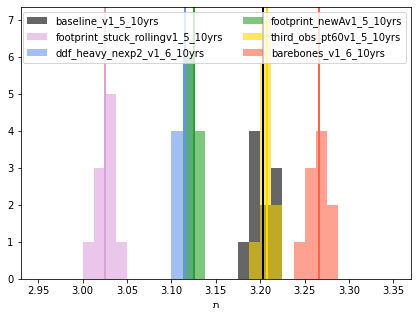

In [26]:
figure(figsize=(7,5))
for which_os in available_os:
  hist(np.mean(all_tlm[which_os],axis=1), 32, range=[2.95, 3.35], alpha=0.6,
       color=os_colors[which_os], label=os_names[which_os])
  axvline(np.mean(all_tlm[which_os]), color=os_colors[which_os], linewidth=2)
legend(ncol=2)
xlabel(chr(0x05ea))
savefig('metrics.pdf', bbox_inches = 'tight', pad_inches = 0 )

## Plotting the negative conditional log likelihood

In [86]:
all_logp = {}
for which_os in available_os:
  all_logp[which_os] = np.stack([f.log_prob(f.info["condition_scaler"](phot_cats[which_os].to_pandas()))
                                 for f in flows[which_os] ], axis=0)


In [114]:
from scipy import stats
n=32
b = stats.mstats.mquantiles(z_cats[which_os]['z_true'], np.linspace(0,1,n, endpoint=True))
# Uncomment for equal z bins
# b = linspace(0,3,n, endpoint=True)

In [115]:
# Computing the metric in redshift bins
mis = {}

for which_os in available_os:
  inds = digitize(z_cats[which_os]['z_true'], b) -1 
  res = zeros(n-1)
  for i in range(n-1):
    res[i] = np.mean( np.mean([(all_logp[which_os][j].flatten()[inds == i]) for j in range(10)]))
    
  mis[which_os] = res

In [116]:
b_centers = 0.5*(b[1:] + b[:-1])

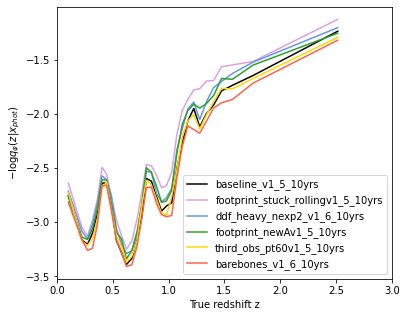

In [126]:
figure(figsize=(6,5))
for which_os in available_os:
  plot(b_centers, - mis[which_os], label=os_names[which_os], color=os_colors[which_os])
legend()
ylabel(r'$- \log q_{\varphi} (z | x_{phot})$')
xlabel('True redshift z')
xlim(0,3);
savefig('logp.pdf', bbox_inches = 'tight', pad_inches = 0 )


(-0.6, 0.6)

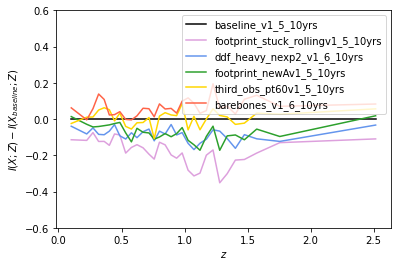

In [123]:
for which_os in available_os:
  plot(b_centers, mis[which_os] - mis['1_4_y10'], label=os_names[which_os], color=os_colors[which_os])
legend(loc='upper right')
xlabel('$z$')
ylabel('$I(X ; Z) - I(X_{baseline} ; Z)$');
savefig('figure4.pdf')
ylim(-0.6,0.6)